# Model Baseline per predir el preu/nit d'un apartament

In [ ]:
import pandas as pd
import requests, io
import numpy as np
import seaborn as sns

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Read Data

In [ ]:
data = pd.read_csv('https://github.com/paubernabe/data/blob/main/juliol.csv?raw=true')
print(data.shape)
data.head(5)

(17079, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20210707180233,2021-07-07,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,Mireia And Maria,2010-01-19,"Barcelona, Catalonia, Spain","We are Mireia (43) & Maria (45), two multiling...",within an hour,98%,81%,f,https://a0.muscache.com/im/users/71615/profile...,https://a0.muscache.com/im/users/71615/profile...,la Sagrada Família,34.0,34.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.40556,2.17262,Entire apartment,Entire home/apt,8,NaN,2 baths,3.0,6.0,"[""Washer"", ""Host greets you"", ""Iron"", ""Hair dr...",$169.00,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,60,2021-07-07,21,0,0,2014-03-02,2019-10-11,4.40,4.55,4.75,4.80,4.90,4.75,4.30,HUTB-002062,t,18,18,0,0,0.23
1,23197,https://www.airbnb.com/rooms/23197,20210707180233,2021-07-08,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,90417,https://www.airbnb.com/users/show/90417,Etain (Marnie),2010-03-09,"Catalonia, Spain","Hi. I'm Etain, though everyone calls me by my...",within a few hours,100%,67%,f,https://a0.muscache.com/im/users/90417/profile...,https://a0.muscache.com/im/users/90417/profile...,El Besòs i el Maresme,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.41291,2.22063,Entire apartment,Entire home/apt,6,NaN,2 baths,3.0,5.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",$240.00,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,NaN,t,17,47,77,169,2021-07-08,52,0,0,2016-01-05,2019-12-15,4.74,4.92,4.92,4.94,4.98,4.67,4.69,HUTB-005057,f,2,2,0,0,0.78
2,32711,https://www.airbnb.com/rooms/32711,20210707180233,2021-07-08,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,https://www.airbnb.com/users/show/135703,Nick,2010-05-31,"Barcelona, Catalonia, Spain",I'm Nick your English host in Barcelona.\r\n\r...,within a day,83%,100%,f,https://a0.muscache.com/im/users/135703/profil...,https://a0.muscache.com/im/users/135703/profil...,Camp d'en Grassot i Gràcia Nova,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia,41.40566,2.1

In [ ]:
data.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.707900e+04,1.707900e+04,1.707900e+04,17030.000000,17030.000000,17079.000000,17079.000000,17079.000000,0.0,16504.000000,16738.000000,17079.000000,17079.000000,17078.000000,17078.000000,17078.000000,1.707800e+04,17078.000000,1.707800e+04,0.0,17079.000000,17079.000000,17079.000000,17079.000000,17079.000000,17079.000000,17079.000000,11984.000000,11787.000000,11790.000000,11784.000000,11789.000000,11783.000000,11782.000000,17079.000000,17079.000000,17079.000000,17079.000000,11984.000000
mean,2.717895e+07,2.021071e+13,1.141008e+08,20.288432,20.288432,41.392045,2.167038,3.371509,NaN,1.662203,2.308221,12.217577,680.562445,12.044033,14.272807,781.087422,2.522904e+05,13.191305,2.517057e+05,NaN,8.582880,21.474384,37.850225,167.022484,32.548100,1.954330,0.345980,4.494317,4.658850,4.590252,4.749701,4.745069,4.761001,4.518300,17.973476,15.592716,2.157152,0.093565,1.012710
std,1.512193e+07,3.964960e+00,1.174252e+08,46.402286,46.402286,0.014600,0.017812,2.227039,NaN,1.004980,1.925432,29.996519,495.803009,29.726489,32.309809,539.480553,2.323879e+07,30.691269,2.318537e+07,NaN,10.928218,22.224067,33.781821,133.622862,65.201064,5.900879,1.061318,0.777112,0.522108,0.559118,0.464123,0.478392,0.386122,0.535292,35.705521,35.179902,8.935116,0.886143,1.200465
min,1.867400e+04,2.021071e+13,3.073000e+03,0.000000,0.000000,41.349430,2.089110,0.000000,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.480228e+07,2.021071e+13,8.964998e+06,1.000000,1.000000,41.380585,2.156680,2.000000,NaN,1.000000,1.000000,1.000000,99.000000,1.000000,2.000000,300.000000,3.300000e+02,2.000000,3.300000e+02,NaN,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,4.400000,4.570000,4.500000,4.710000,4.700000,4.690000,4.380000,1.000000,0.000000,0.000000,0.000000,0.150000
50%,2.852894e+07,2.021071e+13,6.134564e+07,3.000000,3.000000,41.389530,2.167960,2.000000,NaN,1.000000,2.000000,3.000000,1125.000000,2.000000,3.000000,1125.000000,1.125000e+03,3.000000,1.125000e+03,NaN,3.000000,15.000000,35.000000,158.000000,4.000000,0.000000,0.000000,4.680000,4.800000,4.750000,4.890000,4.890000,4.860000,4.630000,3.000000,1.000000,1.000000,0.000000,0.570000
75%,4.085153e+07,2.021071e+13,2.046628e+08,15.000000,15.000000,41.401830,2.177610,4.000000,NaN,2.000000,3.000000,30.000000,1125.000000,30.000000,30.000000,1125.000000,1.125000e+03,30.000000,1.125000e+03,NaN,15.000000,39.000000,67.000000,307.000000,33.000000,1.000000,0.000000,4.900000,4.980000,4.940000,5.000000,5.000000,5.000000,4.830000,15.000000,12.000000,1.000000,0.000000,1.500000
max,5.087501e+07,2.021071e+13,4.112358e+08,547.000000,547.000000,41.463060,2.228480,16.000000,NaN,16.000000,40.000000,1124.000000,3000.000000,1124.000000,1124.000000,9999.000000,2.147484e+09,1124.000000,2.142547e+09,NaN,30.000000,60.000000,90.000000,365.000000,831.000000,133.000000,26.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,174.000000,174.000000,90.000000,15.000000,14.570000


In [ ]:
datanum = data._get_numeric_data()
datanum

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,20210707180233,71615,34.0,34.0,41.405560,2.172620,8,NaN,3.0,6.0,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,NaN,0,0,0,60,21,0,0,4.40,4.55,4.75,4.80,4.90,4.75,4.30,18,18,0,0,0.23
1,23197,20210707180233,90417,2.0,2.0,41.412910,2.220630,6,NaN,3.0,5.0,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,NaN,17,47,77,169,52,0,0,4.74,4.92,4.92,4.94,4.98,4.67,4.69,2,2,0,0,0.78
2,32711,20210707180233,135703,5.0,5.0,41.405660,2.170150,6,NaN,2.0,3.0,2,31,2.0,2.0,31.0,31.0,2.0,31.0,NaN,0,0,0,8,63,0,0,4.31,4.27,4.38,4.81,4.79,4.81,4.40,3,3,0,0,0.62
3,34241,20210707180233,73163,3.0,3.0,41.380620,2.175170,2,NaN,1.0,1.0,30,240,30.0,30.0,240.0,240.0,30.0,240.0,NaN,0,4,34,35,8,0,0,3.40,4.00,3.80,3.60,4.60,4.20,3.40,2,1,1,0,0.06
4,34981,20210707180233,73163,3.0,3.0,41.379780,2.176230,9,NaN,4.0,6.0,4,365,1.0,4.0,365.0,365.0,3.9,365.0,NaN,11,27,57,148,150,1,0,4.54,4.68,4.66,4.68,4.71,4.72,4.50,2,1,1,0,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17074,50862458,20210707180233,47171261,75.0,75.0,41.406321,2.167759,6,NaN,4.0,4.0,32,1125,32.0,32.0,999.0,999.0,32.0,999.0,NaN,23,53,83,358,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,60,0,0,NaN
17075,50863373,20210707180233,51939140,19.0,19.0,41.380819,2.164823,2,NaN,NaN,1.0,31,365,31.0,31.0,365.0,365.0,31.0,365.0,NaN,0,18,33,33,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,0,0,NaN
17076,50864454,20210707180233,411235834,0.0,0.0,41.373161,2.110576,2,NaN,1.0,0.0,1,33,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,30,60,90,90,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,NaN
17077,50867289,20210707180233,297885449,12.0,12.0,41.382955,2.155390,4,NaN,4.0,5.0,31,1125,31.0,31.0,1125.0,1125.0,31.0,1125.0,NaN,20,50,80,355,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,11,0,0,NaN


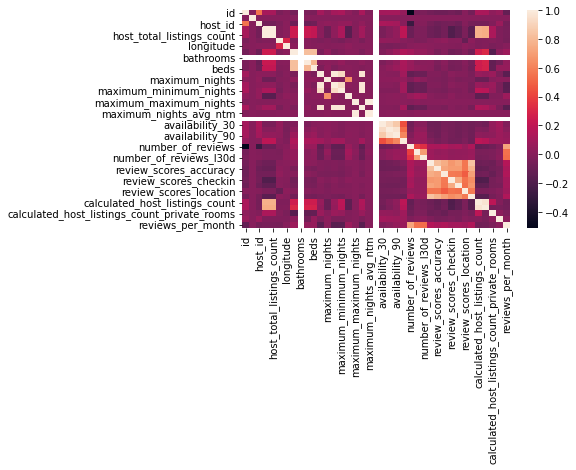

In [ ]:
sns.heatmap(datanum.corr())

## Clean data

In [ ]:
'''
Funció que permet netejar la columna de price i passar-la a float
'''
def clean_str(x):
    if (type(x) == str):
      x = x.replace("$", "").replace(",", "").replace(" ", "")
    return float(x)

'''
Les dades que tenen dos valors possibles es converteixen a Boolean per facilitar
el tractament
'''

d = {'t': True, 'f': False}
data['host_has_profile_pic'] = data['host_has_profile_pic'].map(d)
data['host_is_superhost'] = data['host_is_superhost'].map(d)  
data['host_identity_verified'] = data['host_identity_verified'].map(d)
data['has_availability'] = data['has_availability'].map(d)
data['instant_bookable'] = data['instant_bookable'].map(d)

data['price'] = data['price'].apply(clean_str)

### Data engineering

Es creen noves variables dummy a partir de variables categòriques

In [ ]:
#new categorical columns
y = pd.get_dummies(data.room_type, prefix='rt') #tipus d'habitació
type(y)
data = data.join(y)

y = pd.get_dummies(data.property_type, prefix='property') #tipus de propietat
type(y)
data = data.join(y)

y = pd.get_dummies(data.host_is_superhost, prefix='superhost') #superhost
type(y)
data = data.join(y)

y = pd.get_dummies(data.neighbourhood_group_cleansed, prefix='nb') #grup de veinat
type(y)
data = data.join(y)


## Baseline Model

### Distribució del preu

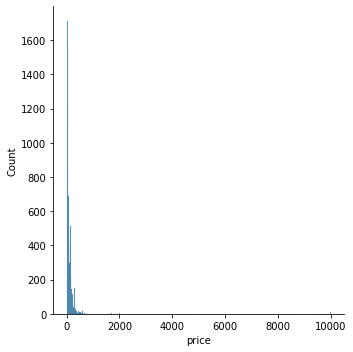

In [ ]:
sns.displot(data, x='price')

In [ ]:
data['price'].describe()

count    17079.000000
mean       115.013994
std        312.660261
min          0.000000
25%         39.000000
50%         69.000000
75%        132.000000
max       9999.000000
Name: price, dtype: float64

Al trobar-se outliers a la columna de preu, es descarten a partir d'un cert llindar.

In [ ]:
data = data[data['price'] < 400]

In [ ]:
data.shape

(16656, 147)

### Split train and test

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2) #seed
print(train.shape, test.shape)

(13324, 147) (3332, 147)


### Selecció de característiques

In [ ]:
features = ['longitude', 'latitude', 'accommodates', 'property_Entire apartment', 'superhost_True']

X = train[features + ['price']].dropna()
y = X['price']
del X['price']

X_test = test[features + ['price']].dropna()
y_test = X_test['price']
del X_test['price']

In [ ]:
print(X.shape, X_test.shape)

(13324, 5) (3332, 5)


In [ ]:
np.sum(X.duplicated())

346

## Models i predicció

- KNN
- Regressió Lineal
- Random Forest

### Model training: KNN

----- EVALUATION ON TRAIN SET ------
RMSE 48.92226574439517
MAE 33.01592268434058
R^2:  0.531731950395919


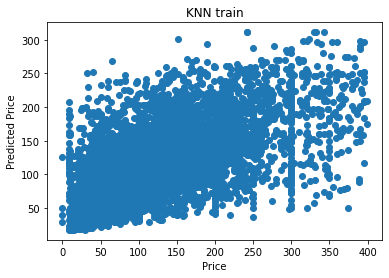

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

n_neighbors = 13
knn = neighbors.KNeighborsRegressor(n_neighbors)
knn.fit(X, y)

y_pred = knn.predict(X)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.title('KNN train')
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

### Model test: KNN

----- EVALUATION ON TEST SET ------
RMSE 52.49436175313564
MAE 35.34384523039985
R^2:  0.471849914747854


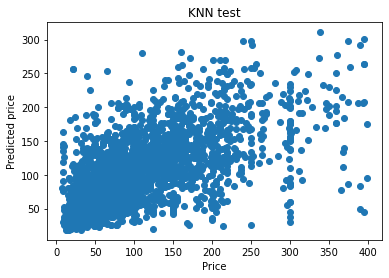

In [ ]:
y_pred_test = knn.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.title('KNN test')
plt.xlabel('Price')
plt.ylabel('Predicted price');
plt.show()

## Linear regression train

----- EVALUATION ON TRAIN SET ------
RMSE 55.34097859872161
MAE 37.88227840158157
R^2:  0.40079549375375234


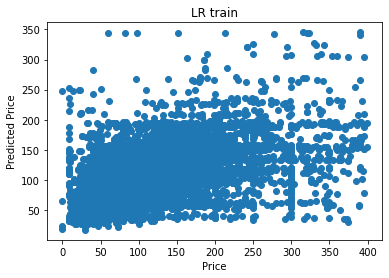

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X, y)


y_pred = lr.predict(X)



print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.title('LR train')
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

## Linear regression test

----- EVALUATION ON TEST SET ------
RMSE 56.22502772399589
MAE 38.01434911999304
R^2:  0.39411333916471447


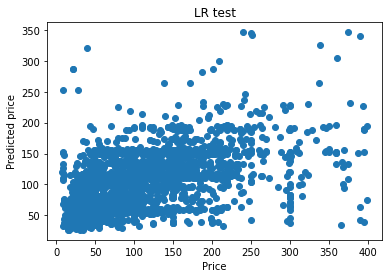

In [ ]:
y_pred_test = lr.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.title('LR test')
plt.xlabel('Price')
plt.ylabel('Predicted price');
plt.show()

## Random forest

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


----- EVALUATION ON TRAIN SET ------
RMSE 20.04280650092812
MAE 13.121267397635535
R^2:  0.921404357405768
OOB SCORE 0.45129328835955096


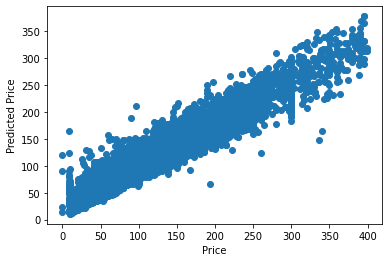

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score = True)
# Train the model on training data
rf.fit(X, y)

## predict training set
y_pred = rf.predict(X)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))
print('OOB SCORE', rf.oob_score_)



plt.scatter(y, y_pred)
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

## Random forest test

----- EVALUATION ON TEST SET ------
RMSE 51.98741745341448
MAE 34.58303457316331
R^2:  0.48200147597371223


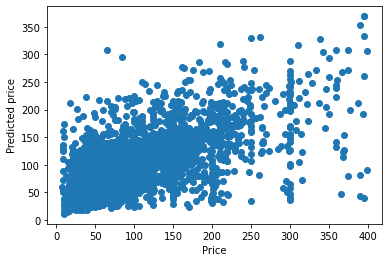

In [ ]:
y_pred_test = rf.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.xlabel('Price')
plt.ylabel('Predicted price');
plt.show()